<a href="https://colab.research.google.com/github/SaraCorra/Projects_dec2023/blob/main/Image_captioning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align= "center">
<b>Deep Neural Network Approach for Captioning Scientific Figures </b>
</p>

<p align = "center">
<i>Corrà Sara, Shaboian Goar</i></p>


# *Auxilliary functions*

Before proceeding with the analysis, we introduce some auxilliary functions which will be used further. Additionally, some of the necessary libraries are loaded.</i>

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/dl_project/extracted_data

/content/drive/MyDrive/dl_project/extracted_data


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [ ]:
import pandas as pd
import json
import numpy as np

In [ ]:
import gc
def clear (): # function to clean the cuda cache and invoke the garbage collector
  torch.cuda.empty_cache()
  gc.collect()

In [ ]:
import json
def json_saver (path, varname):
  with open(path, 'w') as json_file:
    json.dump(varname, json_file)

def json_reader (path):
  with open(path, 'r') as json_file:
    varname = json.load(json_file)
  return varname

# **Introduction**

## **Problem statement**

A comprehensive approach to captioning scientific figures is a pressing issue due to the necessity to convey succinctly the purpose and the interpretation of a plot. This task is of great importance to promote beter understanding of scientific articles and increase the overall quality of the published work, since low-quality captions are a pervasive problem in the scientific field (He et al. (2016)).

To this end, a deep neural network approach was proposed, and the SciCap large-scale figure-caption dataset was introduced in (Hsu, Giles, and Huang (2021)). The advantage of SciCap over FigCap lies in the fact that it uses real-world images, rather than synthetically generated ones, which implies that the patterns in the dataset are more difficult to discern, but provides better capability to include more complicated concepts and insights for the figure descriptions.

## **Dataset description**

> The dataset, along with results of the analysis, can be accessed via the following <a href = "https://drive.google.com/drive/folders/1gfnSxuG67eDzjFbwxVxNtAqoqxU9ch2r?usp=sharing" target = "_blank">link</a>.

### **Retrieving the data**

The dataset was retrieved via the <a href ="https://huggingface.co/datasets/CrowdAILab/scicap" target = "_blank">Huggingface</a> open-source platform. The dataset is comprised of two parts: the images, identified by keys, in Portable Network Graphic format; and the captions that correspond to each image. Additionally, the full paragraphs where the specific plots were mentioned in the source papers are provided.


In [ ]:
#from huggingface_hub import snapshot_download
snapshot_download(repo_id="CrowdAILab/scicap", repo_type='dataset')
# import the dataset from HuggingFace, the data is stored in the
# temporary environment

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/3.46k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

img-split.z04:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z01:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z02:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z03:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

hide_test.json:   0%|          | 0.00/104M [00:00<?, ?B/s]

img-split.z05:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-hide_test.zip:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

img-split.z06:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z07:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z08:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z09:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.z10:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

img-split.zip:   0%|          | 0.00/1.79G [00:00<?, ?B/s]

public-test.json:   0%|          | 0.00/103M [00:00<?, ?B/s]

train-acl.json:   0%|          | 0.00/56.4M [00:00<?, ?B/s]

train.json:   0%|          | 0.00/882M [00:00<?, ?B/s]

val.json:   0%|          | 0.00/127M [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/datasets--CrowdAILab--scicap/snapshots/cdc5cf0fffa663f66bdf9400d6a82c9d05b74869'

In [ ]:
# the training and test datasets with the attributes and observations
# were retrieved
names = ['train', 'val']
for name in names:
  path = f"/content/drive/MyDrive/dl_project/extracted_data/{name}.json"
  json_saver (path, name)

The images were initially stored in separate splits, which were subsequently consolidated in a single zip file.

In [ ]:
%%capture
!zip -F /root/.cache/huggingface/hub/datasets--CrowdAILab--scicap/snapshots/cdc5cf0fffa663f66bdf9400d6a82c9d05b74869/img-split.zip --out img.zip
# zipping together all the different splits and storing the resulting
# .zip file in the Drive folder

### **Visualizing the dataset**

Some of the instances of the SciCap dataset are demonstrated below.

In [ ]:
data_plot=loader(dataset = dataset (captions_train, "train", img_dirs_train, 10, transform), batch_size=6, shuffle=False)

X,y=next(iter(data_plot))
X=X.cpu()

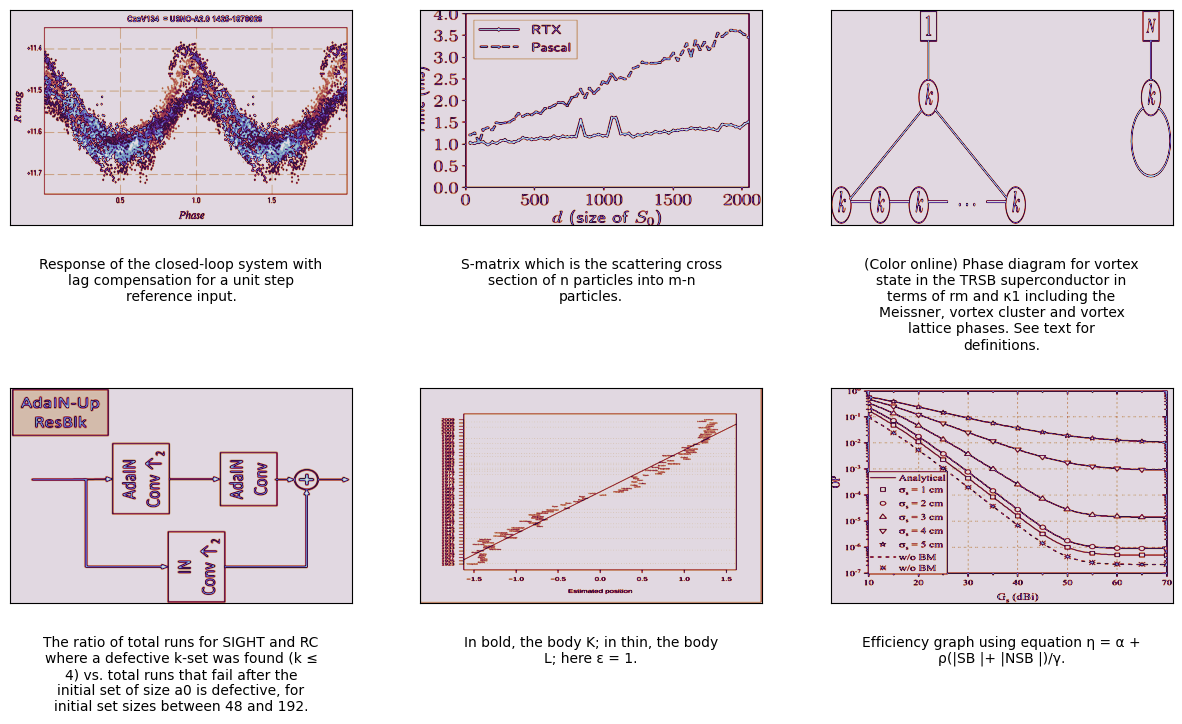

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap  #  the textwrap module

_, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

# Assuming you have a list of captions for each image
train_captions = train_cap['caption_no_index'].iloc[:6]
captions = [caption for caption in train_captions]

# Set the maximum width for each line
max_line_width = 40

for i, (ax, img) in enumerate(zip(axes, X)):
    ax.imshow(np.asarray(X[i][0]), cmap='twilight')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Wrap the caption text to multiple lines
    wrapped_caption = textwrap.fill(captions[i], width=max_line_width)

    # Set the wrapped caption below the image using text
    ax.text(0.5, -0.15, wrapped_caption, transform=ax.transAxes, ha='center', va='top', fontsize=10)

plt.show()


The dataset includes figures from articles published during the time period of 2010-2020. The scientific were published in the open-access archive <a href = "https://arxiv.org/" target = "_blank" >arXiv</a>. Only articles categorised Comptuter Sciences (cs) and Machine Learning (stat.ML) were included. The informtation possibly included in the source files was disregarded, and the figures with subfigures were ommitted from the dataset.

Initially, the 80% - 10% - 10% split was <a href = "https://crowdailab.notion.site/crowdailab/The-1st-Scientific-Figure-Captioning-SciCap-Challenge-47b914e092dd4965af7b432f6b2d42e8" target = "_blank">proposed</a> for the training, validation and test datasets. Figures from the different scientific papaers were assigned o the same split.


### <b>Exploratory analysis </b>

The distribution of the length of the captions was investigated to promote better understanding of the SiCap dataset.

In [ ]:
# load the datasets
train = json_reader ("/content/drive/MyDrive/dl_project/extracted_data/train.json")
test = json_reader ("/content/drive/MyDrive/dl_project/extracted_data/val.json")

In [ ]:
def lengths (df):
    data = {'id': [], 'length': []}
    for i in range(len(df['annotations'])):
        caption = df['annotations'][i]['caption']
        # length of each caption
        length = len(caption.split())
        # append to later convert to pd df
        data['id'].append(df['images'][i]['id'])
        data['length'].append(length)
    out = pd.DataFrame(data)
    return out
total_lengths = lengths (train)

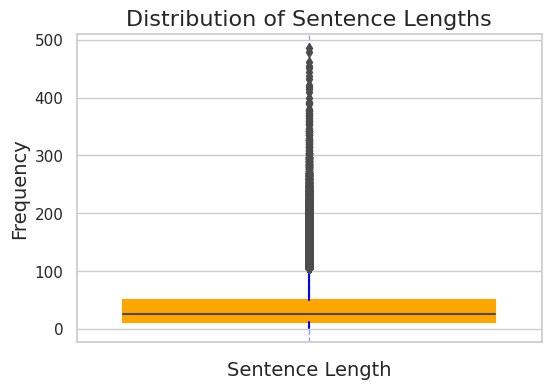

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

sns.set(style="whitegrid")
ax = sns.boxplot(y=total_lengths['length'], color='blue',
                 boxprops=dict(facecolor='blue', color='orange'),
                 whiskerprops=dict(color='blue'), showfliers=True, showcaps=False)

plt.grid(axis='x', linestyle='--', alpha=0.4, color="blue")
plt.title('Distribution of Sentence Lengths', fontsize=16)
plt.xlabel('Sentence Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The boxplot demostrates that 1.5 IQR of the distribution of the length of the sentences is below the value of 100, with extreme values observed for a portion of the captions. As the length of the input sequence grows, the natural language processing model produces more errors in the output due to the difficulty of capturing long-range dependencies and maintaining context over extended portions of text. Hence, only data points for which the length of the caption was less than 100 were considered.

In [ ]:
# choose only the captions with less than 100 words
short_captions = total_lengths [total_lengths ['length'] <= 100]
short_captions_test = total_lengths_test [total_lengths_test ['length'] <= 100]
# select the image ids for the shorter sentences
short_ids = list ((short_captions ['id']))
total_lengths_test = lengths (test)
short_ids_test = list (short_captions_test ['id'])

## <b> Setting up the dataset </b>

The data points for training, validation and test sets were sampled from the generated indices that correspond to the selected length of the captions.

For intial tuning of hyperparameters, a smaller dataset of 10.000 images in total will be used. For final training and testing onthe optimal model, the dataset of 20.000 images will be used. The split is 80%/10%/10% for the training, validation and testing dataset.

The validation dataset is derived from the original training dataset through the process of splitting, where a portion of the initial training data is set aside specifically for validation purposes.

Considering the initial size of the full dataset is over 300.000 images, the necessity to sample the images to use in the analysis appropriately arose. Thus, random sampling was used to eliminate sampling bias.

In [ ]:
import random
random.seed (42)
# sample the 18.000 indices for train and validation sets
random_num = random.sample(short_ids, k=18000)
# split the randomly drawn indices for train and val
random_num_train = random_num [:16000]
random_num_val = random_num [16000:]
random.seed (42)
# sample 2.000 indices for test set
random_num_test = random.sample (short_ids_test, k = 2000)

In [ ]:
# now select the indices that will be used for the smaller validation step
random_num_train_10k = random_num_train [:8000]
random_num_val_10k = random_num_val [:1000]
# nothing for testing because it will be only performed on the full dataset

In [ ]:
train_indices_20k = random_num_train
train_indices_20k.sort ()
val_indices_20k = random_num_val
val_indices_20k.sort ()
test_indices_20k = random_num_test
test_indices_20k.sort ()
train_indices_10k = random_num_train_10k
train_indices_10k.sort ()
val_indices_10k = random_num_val_10k
val_indices_10k.sort()

In [ ]:
# save the sampled values
#json_saver ("/content/drive/MyDrive/dl_project/extracted_data/final/train_indices_20k.json", train_indices_20k)
#json_saver ("/content/drive/MyDrive/dl_project/extracted_data/final/train_indices_10k.json", train_indices_10k)
#json_saver ("/content/drive/MyDrive/dl_project/extracted_data/final/val_indices_20k.json", val_indices_20k)
#json_saver ("/content/drive/MyDrive/dl_project/extracted_data/final/val_indices_10k.json", val_indices_10k)
#json_saver ("/content/drive/MyDrive/dl_project/extracted_data/final/test_indices_20k.json", test_indices_20k)

With the indices chosen, it is possible to set up the dataframes that will only contain the selected observations, and hence can be used in further analysis. Additiionally, the directories of the selected images are stored in order to facilitate storing the data.

In [ ]:
def load_data (which_set, split, isTest = False):
  if isTest:
    data_path = "/content/drive/MyDrive/dl_project/extracted_data/val.json"
    with open(data_path, 'r') as json_file:
      data = json.load(json_file)
  else:
    data_path = "/content/drive/MyDrive/dl_project/extracted_data/train.json"
    with open(data_path, 'r') as json_file:
      data = json.load(json_file)
  ind_path = f"/content/drive/MyDrive/dl_project/extracted_data/final/{which_set}_indices_{split}k.json"
  with open(ind_path, 'r') as json_file:
    random_num = json.load(json_file)
  cap = pd.DataFrame(data ['annotations'])
  img = pd.DataFrame(data ['images'])
  cap = cap [cap ['image_id'].isin(random_num)].reset_index(drop = True)
  img = img [img ['id'].isin(random_num)].reset_index(drop = True)
  img_dirs = [x for x in img ['file_name']]
  return cap, img, img_dirs

In [ ]:
# at this step, we store the dataframes for the smaller dataset that will be
# used in validation step
train_cap, train_img, img_dirs_train = load_data ("train", 10)
val_cap,val_img, img_dirs_val = load_data ("val", 10)

### <b>Storing the data</b>

The following step is to extract the .png representations of the images from the compressed ZIP file and store them in a folder. A system of subfolders was used in order to alleviate the burden on the CUDA memory during the training process. To this end, each 1.000 images for the training set is stored in a subdirectory of the same parent directory.

In [ ]:
import zipfile
import os

In [ ]:
zip_file_path = '/content/drive/MyDrive/dl_project/extracted_data/img.zip'
extracted_dir = '/content/drive/MyDrive/images_10k/train'
i = 0
# start counting from 1
current_folder = 1
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # iterate over the names of the .png files of the selected images
    for dirs in img_dirs_train:
        file_name_pattern = f'share-task-img-mask/arxiv/train/{dirs}'
        try:
            # move to the next folder once 1.000 images are placed in the current
            # folder
            if i > 0:
              if i % 1000 == 0:
                print(f"Extracted another 1k pngs to folder {current_folder}")
                current_folder += 1
            folder_path = os.path.join(extracted_dir, str(current_folder))
            zip_ref.extract(file_name_pattern, folder_path)
            i += 1
        except KeyError:
            print(f"File not found: {file_name_pattern}")
print("Extraction complete.")

Extracted another 1k pngs to folder 1
Extracted another 1k pngs to folder 2
Extracted another 1k pngs to folder 3
Extracted another 1k pngs to folder 4
Extracted another 1k pngs to folder 5
Extracted another 1k pngs to folder 6
Extracted another 1k pngs to folder 7
Extraction complete.


For test and validation dataset, each of which consist of 2.000 and 1.000 images respectively, it is not necessary to create the subdirectory structure, hence they are proccessed in a different way.

In [ ]:
# the following function is used where there is no necessity
# to use the subfolder structure
def png_saver (zip_path, extraction_path, img_identifiers, isTest = False):
  if isTest:
    data = "val"
  else:
    data = "train"
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for dirs in img_identifiers:
        file_name_pattern = f'share-task-img-mask/arxiv/{data}/{dirs}'
        try:
            zip_ref.extract(file_name_pattern, extraction_path)
        except KeyError:
            print(f"File not found: {file_name_pattern}")

In [ ]:
extraction_path = '/content/drive/MyDrive/images_10k/val'
png_saver (zip_file_path, extraction_path, img_dirs_val)

# **Deep learning model architecture**

## <b> Framework for image captioning </b>

A common approach for the image captioning task is formulating it in the Machine Learning framework, where the input images are translated into sentences by the means of an encoder-decoder architecture (Chen et al. (2019)).

<figure style="text-align: center;">
  <img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png
' alt='Encoder-decoder'>
</figure>

<p align="center">
  <i>Example of the CNN-LSTM encoder-decoder architecture for image captioning for the COCO dataset.</i>
  <a href="https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning" target="_blank">Source</a>
</p>

To approach the problem of scientific figure captioning for the SciCap dataset, the baseline model used was CNN + LSTM architecture (Hsu, Giles, and Huang (2021)). This allows to extract the features from the images using the convolutional network, which are then used in the LSTM decoder for word generation.

A similar approach was implemented in this project: an encoder-decoder architecture was used, with two different specifications for the encoder based on GoogLeNet and ResNet convolutional networks, and Since the dataset provides both visual and text data, it was possible to leverage both sources of data to build a comprehensive model.

Furthermore, as reference points, the following PyTorch tutorials were used:

1.   <a href = "https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning" target = "_blank">Image captioning</a> on the COCO dataset, implemented by research scientist at NAVER AI Lab Yunjey Choi.
2.   <a href = "https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/more_advanced/image_captioning" target = "_blank">Image captioning</a> on the Flickr18 dataset, implemented by the Store No. 8 Machine Learning engineer Aladdin Persson.

## **Encoder architecure**

In [ ]:
%%capture
!pip install d2l==1.0.3

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

The encoder comprises the convolutional network (CNN) aimed at feature extraction from the image data, for which purpose the convolutional neural networks have demonstrated significant reduction in error rates in ImageNet competition (Krizhevsky, Sutskever, and Hinton (2012)).

A convolution is defined as follows (Zhang et al. (2023)):

$$(f * g )(i, j) = \Sigma_a \Sigma_b f(a, b) g(i - a, j - b), $$

where f and g are the functions, and a and b are the indices.

The benefit of the convolutional neural networks for image processing is partially explained by the fact that they fullfil the translation invariance and the locality principles (Zhang et al. (2023)). More specifically, translation invariance refers to the concept that the network should have a similar response to the same patch of the image irrespective of the exact part of the image it appears on. The locality pinciple implies that the network should be able to focus on small regions of the image, and from them make aggregated predictions on the whole image, thus using the local information to assess the output.  

Additionally, an advantage that CNNs provide is the reduction of the parameter space. This benefit arises from the concept of sparse connectivity: since the kernel used for the convolution is smaller than the input, it becomes possible to detect important features while storing fewer parameters (Goodfellow, Bengio, and Courville (2016)).

Two convolutional architectures that have demonstrated high performance have been chosen to attempt to address the figure captioning task: GoogLeNet and the ResNet-18.

### **GoogLeNet**

GoogleNet, also known as Inception, is a deep convolutional neural network (CNN) architecture that gained prominence for winning the ImageNet Large Scale Visual Recognition Challenge in 2014. Developed by researchers at Google, the key innovation of GoogleNet lies in its unique inception modules.

The core of the net comprises the initial convolutional layers tasked with processing the image, extracting foundational low-level features. Subsequently, a series of convolutional blocks form the body, further refining these features. Ultimately, the head of the network translates the accumulated features into the necessary classification.

GoogNet uses a stack of a total of 9 inception blocks, arranged into three groups with max-pooling in between, and global average pooling in its head to generate its estimates. Max-pooling between inception blocks reduces the dimensionality (Zhang, Aston, et al., 2023).

It employed around 7 million parameters, which represented a 9x reduction with respect to its predecessor AlexNet, which used 60 million parameters. The computational cost of Inception is also much lower than VGGNet or its higher performing successors . This has made it feasible to utilize Inception networks in big-data scenarios. (Szegedy, Christian, et al., 2016).


__Inception__

<p align='center'><img src='https://media.geeksforgeeks.org/wp-content/uploads/20200429201304/Incepption-module.PNG' alt='Understanding Googlenet Model - Cnn Architecture - Geeksforgeeks'></p>

<p align="center">
  <i>Inception modules</i>
  <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf" target="_blank">Source</a>
</p>



The inception module represents an architectural innovation in convolutional neural networks (CNNs). Introduced to enhance the network's ability to capture complex hierarchical patterns, the inception module employs a multi-branch structure incorporating filters of different sizes (1x1, 3x3, and 5x5 convolutions).

  The inclusion of 3x3 MaxPooling reduces output dimensions, moreover, each of the four branches use appropriate padding to give the input and output the same height and width. The concatenation of resulting feature maps enables the network to discern patterns at various scales.

  Through this parallel processing, the network achieves more effective feature extraction. Additionally, 1x1 filters are applied to decrease the spectral dimension. This spectral dimension represents the band; for example, if an input size for an inception block is 28x28x192, then 192 is called a band or spectral dimension (<a href = "https://nitishkumarpilla.medium.com/understand-googlenet-inception-v1-and-implement-it-easily-from-scratch-using-tensorflow-and-keras-5404239f361" target = "_blank">Source</a>).  All layers are thus concatenated into a single output vector forming the input of the next stage.

The inception module's ingenious design significantly contributes to the model's overall performance by facilitating the extraction of both fine-grained and high-level features from the input data while enabling all filters to be learned during the process.


<figure style="text-align: center;">
  <img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*k-lzAjdSAFOpt9R6SD_58w.jpeg' alt='Deep Learning: Googlenet Explained | By Richmond Alake | Towards ...'>
</figure>

<p align="center">
  <i>GoogleNet architecture</i>
  <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf" target="_blank">Source</a>
</p>


Inception layers are repeated many times, leading to a 22-layer deep model in the the GoogNet model. The overall number of layers (independent building blocks) used for the construction of the network is about 100. ( Szegedy, Christian, et al., 2015).

<p align='center'><img src='https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG' alt='Understanding Googlenet Model - Cnn Architecture - Geeksforgeeks'></p>

<p align="center">
  <i>Table of GoogleNet architecture</i>
  <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf" target="_blank">Source</a>
</p>



The Table above illustrates the architectural dimensions of GoogNet, as presented in the seminal paper "Going Deeper with Convolutions" by Szegedy et al. The table provides a comprehensive overview of the network's structure, detailing the dimensions at various stages of the architecture. Each row corresponds to a different inception module, showcasing the evolution of feature maps as information passes through the network.

The dimensions include input size, kernel size and the number of filters. For instance, the first row indicates the input being processed by 7x7 convolutions with 64 filters, resulting in a 112x112 feature map. The two columns named #3x3 reduce and #5x5 reduce represent the number of 1x1 filters used before applying 3x3 and 5x5 filters on the input. If the value of #3x3 reduce is 64, it means that 64 filters of 1x1 are applied before applying a 3x3 filter on the input. Moreover,  max-pooling layers with stride 2 are used to halve the resolution of the grid.


In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                            Inception(160, (112, 224), (24, 64), 64),
                            Inception(128, (128, 256), (24, 64), 64),
                            Inception(112, (144, 288), (32, 64), 64),
                            Inception(256, (160, 320), (32, 128), 128),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

    def __init__(self, embed_size=200):
        super(GoogleNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(embed_size))
        self.net.apply(d2l.init_cnn)

The GoogLeNet outputs have the following representation.

In [ ]:
 GoogleNet ().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 200])


### **ResNet**

Residual neural network, or ResNet, was introduced as a novel way to boost the time efficiency of training deep neural networks. This task became urgent as research demonstrated that additional layers introduced to the deep neural network architecture result in noticeable reductions in the error rates (Simonyan and Zisserman (2014)). However, the problem of degradation, which implies saturation and eventual decrease of the accuracy of the predictions, has been observed for deeper networks (He et al. (2016)).

<p align='center'><img src='https://i.imgur.com/PHJbzQ4.png' alt=Degradation' width = 500></p>

<p align="center">
  <i>Degradation problem, two networks for CIFAR-10 dataset.</i>
  <a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">Source</a>
</p>

Thus, the residual framework was introduced to tackle this issue, as well as the vanishing gradient problem.

The core idea behind the ResNet architecture is using residual, or skip, connections, which imply skipping one or more layers in the feedforward architecture.

<p align='center'><img src='https://i.imgur.com/44khxoo.png' alt=Residual block'  width = 400></p>

<p align="center">
  <i>Skip connection in a residual block.</i>
  <a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">Source</a>
</p>

An important benefit of this approach lies in the fact that the residual connections increase neither the complexity of the network, nor do they add additional parameters to be optimized.

Furthermore, it was demonstrated on the Imagenet dataset that such architecture allows to optimize the network efficiently where the counterpart models focused on the depth of the network exhibit higher training errors (He et al. (2016)).  

The ResNet architecture has demonstrated outstanding results on the ImageNet, <a href = "https://people.idsia.ch/~juergen/microsoft-wins-imagenet-through-feedforward-LSTM-without-gates.html#:~:text=Microsoft%20Research%20dominated%20the%20ImageNet,the%20great%20results%20%5B2%5D!" target = "_blank">winning</a> the competition in 2015. The model has demonstrated good performance for a variety of tasks, including detection and segmentation.

For the ImageNet competition, ResNet-152 was used, which incorporates 152 layers; below, a less deep ResNet-18 implementation will be introduced to be used for the scientific caption task.

<p align='center'><img src='https://i.imgur.com/GohKDcf.png' alt=Residual block' width = 600 height = 300></p>



<p align="center">
  <i>ResNet-18 architecture.</i>
  <a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">Source</a>
</p>


The structure of the ResNet-18 model is demonstrated above. Initially, a 7x7 convolution (output of 64 channels) is used with stride of size 2, after which a 3x3 max-pooling layer with stride 2 is applied. Afterwards, batch normalization is applied, which is implemented to alleviate computational burden and increase accuracy, for it allows to normalize the outputs of the layer for each of the batches processed. Additionally, this ensures that the network is less sensitive to initialization values and can even introduce regularization (Ioffe and Szegedy (2015)).

For mini-batch optimization, which is the technique used in this project, batch normalization is approached in the following way:

<p align='center'><img src='https://i.imgur.com/ksisoSW.png' alt=Residual block' width = 400></p>

<p align="center">
  <i>Batch normalizing transformation.</i>
  <a href="http://proceedings.mlr.press/v37/ioffe15.pdf" target="_blank">Source</a>
</p>

After the batch normalization layer, 4 residual modules are introduces,  the first one taking as input the number of channels, 64, obtain at the previous layer. Each of the following modules increases the number of output channels, reaching the value of 512 channels at the final block. Each module consists of two identical residual blocks for the ResNet-18 architecture. The residual blocks comprise two batch-normalizaed 3x3 convolutions, with the ReLU activation appplied at the intermediate step.

At the final stage, a global average pooling is used to summarize the spatial information. A fully connected layer is implemented afterwards, which, with an adjustment of the output size, allows to obtain a resulting feature vector that would be used as input to the decoder.

In the implementation below, the ResNet18 net was implemented
from scratch, without loading pretrained weights. The implementation is taken from Zhang et al. (2023).

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        # lazy modules derive the shapes of their parameters from the first
        # input to their forward method
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # skip connection
        Y += X
        return F.relu(Y)

In [ ]:
class ResNet(d2l.Classifier):
  def __init__(self, arch, embed_size):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      # stack residual blocks with specification for different number of channels
      # on top of one another
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(embed_size)))
    self.net.apply(d2l.init_cnn) # initialise Glorot weights

  def b1(self):
      return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
          # max pooling here

  def block(self, num_residuals, num_channels, first_block=False):
      blk = []
      for i in range(num_residuals):
          if i == 0 and not first_block:
              blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
          else:
              blk.append(Residual(num_channels))
      return nn.Sequential(*blk)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, embed_size = 200):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                      embed_size)

Below, the representation of the outputs of the ResNet-18 layers is provided.

In [ ]:
ResNet18().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Sequential output shape:	 torch.Size([1, 200])


### **Final encoder**

The the networks described above are used to obtain the feature vectore, to which the ReLU activation is applied, as well as dropout for regularization, to obtain the final feature vector to be used as input for the decoder.

In [ ]:
import torch.nn.functional as F
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self,  embed_size, dropout, net=None):
        super(EncoderCNN, self).__init__()
        if net=='ResNet':
          self.resnet18 = ResNet18(embed_size = embed_size)
          self.net='ResNet'
        elif net=='GoogleNet':
          self.googleNet = GoogleNet(embed_size = embed_size)
          self.net='GoogleNet'
        else:
            raise ValueError("Invalid net type. Supported types are 'ResNet' and 'GoogleNet'.")
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, images):
        if self.net == 'ResNet':
            features = self.resnet18(images)
        elif self.net == 'GoogleNet':
            features = self.googleNet(images)
        features=self.relu(features)
        features=self.dropout(features)

        return features

## **Decoder architecture**

The decoder is aimed at combining the information obtained from the images, in the form of the feature vector provided by the encoder, with text information, processing it, and translates the information stored in the resulting hidden states back into text representation.

### <b>Preprocessing for the natural language processing task</b>

#### **Text normalization**

In order to be able to engage in natural language processing, it is essential to transform the textual representation of the data in a numeric form, which can be taken as input by the computational model.

The first stage of this process is text normalization. The whole text was converted to lowercase representation to avoid case sensitivity; afterwards, the instances of multiple sequential space characters were eliminated. To reduce noise in the data, only latin characters were kept in the final output, as well as the dot and the dash. The indices of the figures were eliminated as well, and all the numbers were replaced by the token "NUM", to avoid excessive noise in the data, following the approach of Hsu, Giles, and Huang (2021).

In [ ]:
import re

In [ ]:
def num_replace (string):
  l = string.split ()
  for i in range (len (l)):
    for j in l [i]:
      if j.isdigit ():
        l [i] = "NUM"
        break
  return " ".join (l)

In [ ]:
def text_processing(df):
    for index, row in df.iterrows():
        caption = row['caption']
        caption = caption.lower()
        caption = caption.replace("\s+", " ")
        caption = re.sub(r'[()\[\]{}]', '', caption)
        caption = re.sub(r'[^a-zA-Z\s\d.-]', '', caption)
        caption = num_replace (caption)
        caption = re.sub(r'\b(?:figure|fig\.)\s*', '', caption)

        caption = "SOS " + " ".join([word for word in caption.split() if len(word) > 1]) + " EOS"
        df.at[index, 'caption'] = caption

In [ ]:
captions_train = train_cap [['image_id', 'caption']]
captions_val = val_cap [['image_id', 'caption']]
text_processing (captions_train)
text_processing (captions_val)

Additionally, end-of-sentence and start-of-sentence tokens, which will be discussed further, were added.

#### **Tokenization**

The next stage  is tokenization, which aims at splitting the text into tokens. This guarantees that we transform full string text representation into smaller meaningful string units.

<!-- Center-justified image -->
<p align="center">
  <img src="https://i.imgur.com/URAAqGf.png" alt="Tokenization" width = 500>
</p>

<!-- Source link -->
<p align="center">
  <i>Example of tokenization.</i>
  <a href="https://spacy.io/usage/spacy-101" target="_blank">Source</a>
</p>



For this task, the open-source library spaCy was used, specifically, the "<a href = "https://spacy.io/models/en#en_core_web_sm-labels" target = "_blank">en_core_web_sm</a>" tokenizer, which was trained for the English language. This tokenizer is particularly suitable for neural network models.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

#### <b>Vocabulary</b>

The vocabulary that will be used for translations to text representation is built on the test dataset, and the unknown word that will be encountered in test and validation will be assigned the "UNK" token.

In [ ]:
import numpy as np
vocab = dict()
for _, row in captions_train.iterrows():
    sentence = nlp.tokenizer(row['caption'])
    for word in sentence:
        if word.text not in ["SOS", "EOS"]:
            if word.text not in vocab:  # Use word.text as the key
                vocab[word.text] = 1
            else:
                vocab[word.text] += 1

#### <b>Encodings</b>

In order to be able to use text data in  a computer model, it must be converted to an appropriate representation. To that end, each caption was encoded using index values obtain from the vocabulary. The special tokens described above, as well as the padding token, which will be described further, were added as well.

In [ ]:
label2id = {str (k): (v + 4) for v, k in enumerate(vocab)} # select the index
id2label = {(v + 4): str (k) for v, k in enumerate(vocab)}
id2label [0] = "PAD"
id2label [1] = "SOS"
id2label [2] = "EOS"
id2label [3] = "UNK"
label2id ["PAD"] = 0
label2id ["SOS"] = 1
label2id ["EOS"] = 2
label2id ["UNK"] = 3

In [ ]:
def create_tokens (row, label2id):
  return [label2id[str(word)] if (str(word) in vocab or str(word) in ["PAD", "SOS", "EOS"]) else label2id["UNK"] for word in nlp.tokenizer(row)]

In [ ]:
captions_train ['encodings'] = captions_train ['caption'].apply(lambda x: create_tokens(x, label2id))
captions_val ['encodings'] = captions_val ['caption'].apply(lambda x: create_tokens(x, label2id))

## **Building the decoder**

To construct the decoder that will achieve the presented task, it is necessary to include several layers which are described in detail below.

### **Embedding layer**

This layer is aimed at mapping the encoding vector space into a distributed representation, which provides a way to include different patterns of information of a word as input to the network (Zhang et al. (2023)). In order to be able to account for semantic relationships between the words in the captions, the pretrained <a href = "https://nlp.stanford.edu/projects/glove/" target = "_blank">Glove embeddings</a> were used. Glove has a vocabulary size of 400.000, and it was trained on Wikipedia and Gigaword 5 corpus. The resulting embeddings provide a way to map the encodings into a vector space, taking into consideration various dimensions of the differences betwenn words, thus providing a comprehensive representation of the semantic meaning (Pennington, Socher, and Manning (2014)).


<!-- Center-justified image -->
<p align="center">
  <img src="https://nlp.stanford.edu/projects/glove/images/man_woman.jpg" alt="Glove" width = 500>
</p>

<!-- Source link -->
<p align="center">
  <i>Visual representation of Glove embeddings.</i>
  <a href="https://nlp.stanford.edu/projects/glove/" target="_blank">Source</a>
</p>

Glove embeddings of size 200 were chosen for the analysis to obtain a balance between complexity of the model and the amount of information introduced.


In [ ]:
#zip_path = '//content/drive/MyDrive/dl_project/data/glove.6B.zip'
#extract_path = '/content/drive/MyDrive/dl_project/data/'
#import zipfile

#def extract_from_zip(zip_file_path, extract_to_path):
#    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#        zip_ref.extractall(extract_to_path)

#extract_from_zip (zip_path, extract_path)

In [ ]:
embedding_dim = 200
glove_embedding_path = "/content/drive/MyDrive/dl_project/extracted_data/glove.6B.200d.txt"

embeddings_index = {}
with open(glove_embedding_path, encoding='utf-8') as f:
    for line in f:
      values = line.split()
      word = values[0] # Words in the GloVe file
      coefs = np.asarray(values[1:], dtype='float32') # Vectors in the Glove file
      embeddings_index[word] = coefs # associate to each word its GloVe vector

In order to use the pretrained embeddings, it is necessary to assign to each word the corresponding vector from the Glove vocabulary. For the words not present in that vocabulary, the embedding will be initialised at 0 values.

In [ ]:
glove_matrix = np.zeros((len(vocab) + 4, embedding_dim)) # for the unknown
for id, lab in id2label.items():
  embedding_vector = embeddings_index.get(lab)
  if embedding_vector is not None:
    glove_matrix [id] = embedding_vector

In [ ]:
glove_embeddings = torch.tensor(glove_matrix).to(device)
glove_embeddings=glove_embeddings.float()

### **Long Short-Term Memory**

The natural language processing task is aimed at modelling data that has a sequential nature while tackling the problem of the vanishing gradient. Long short-term memory models have been proposed as an improvement over the Recurrent Neural Networks since they are <a href = "https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577" target = "_blank">capable</a> of efficiently dealing with the exploding and vanishing gradient problems. The LSTM aim at keeping track of sequential information by using the following structure:


<!-- Center-justified image -->
<p align="center">
  <img src="https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png" alt="LSTM" width = 500>
</p>

<!-- Source link -->
<p align="center">
  <i>LSTM representation.</i>
  <a href="https://databasecamp.de/en/ml/lstms" target="_blank">Source</a>
</p>

At the core of an LSTM network are memory cells, which can store information over extended periods, thus increasing the capability to tackle sequential data. The cell state allows to maintain a flow of information by keeping track of the long-term memory, which can be updated according to the values of the input by using the forget gate. The input gate serves the purpose of determining which information is relevant and should be kept for the subsequent steps of the LSTM. The output gate uses the information of the current input, the hidden state and the updated cell state to update the hidden state h(t) (Goodfellow, Bengio, and Courville (2016)).

The start of sentence (SOS) and end of sentence (EOS) tokens added above are used by the LSTM to distinguish the beginnings and the ending of separate captions, and uses them as inputs for the network that it should train to recognize accordingly.

The LSTM network is widely used in the natural language processing tasks, and has demonstrated good performance for text generation purposes.

The ability of LSTMs to selectively remember or forget information is crucial for their success in capturing long-term dependencies. This is achieved through the gating mechanisms, which are trainable parameters that dynamically adjust the flow of information within the network. The sigmoid activation function is employed in the gates to output values between 0 and 1, effectively controlling the proportion of information to be passed through.

The input to the LSTM layer is the word embedding concatenated with the feature vector obtained from the encoder. 256 hidden units will be used to capture the patterns in the data.

At the final stage, a linear layer is introduce to scale the output to the size of the vocabulary obtained at a previous stage. This ensures that logits for making predictions on the words in the output captions will be calculated.

In [ ]:
class DecoderLSTM (nn.Module):
  def __init__ (self, embed_size, hidden_size, vocab_size, num_layers, dropout):
    super (DecoderLSTM, self).__init__ ()
    #embedding:
    self.embed = nn.Embedding.from_pretrained(glove_embeddings, freeze=False)
    # lstm:
    self.lstm = nn.LSTM (embed_size, hidden_size, num_layers)
    # linear layer:
    self.linear = nn.Linear (hidden_size, vocab_size)
    # dropout
    self.dropout = nn.Dropout (dropout)

  def forward (self, features, captions):
    emb = self.dropout (self.embed (captions))

    # concatenate with visual information
    emb = torch.cat ((features.unsqueeze (1), emb), dim = 1)
    # unsqueeze to match the feature vec for single image with
    # embeddings for every word in sentence

    hiddens, _ = self.lstm (emb)

    outputs = self.linear (hiddens)
    return outputs

## **Encoder-decoder architecture**

Finally, the full encoder-decoder architecture is set up. The output of the encoder is the feature vector that is the representation of the input data is fed into the decoder in order to use that information in the natural language processing task. The visual information, stored in the feature vector, is concatenated with the word embeddings for the input captions, and this forms the input to the decoder.

In [ ]:
class Image_to_Caption (nn.Module):
  def __init__ (self, embed_size, hidden_size, vocab_size, num_layers, dropout, net = None):
    super (Image_to_Caption, self).__init__ ()
    self.encoder = EncoderCNN (embed_size, dropout, net)
    self.decoder = DecoderLSTM (embed_size, hidden_size, vocab_size, num_layers,dropout)

  def forward (self, images, captions):
    features = self.encoder (images)
    outputs = self.decoder (features, captions)
    return outputs

Below, a representation of the deep neural network is provided, for the case of 1 image and 1 caption of length 100, with the input and output dimensions. The parameters used to create the representation correspond to the parameters that will be specified for the model below. The encoder-decoder with the GoogLeNet encoder implementation is demonstrated.

In [ ]:
%%capture
!pip install torchinfo

In [ ]:
import torchinfo
mod = Image_to_Caption (200, 256, 16537, 2, 0.1, net = "GoogleNet")
torchinfo.summary(mod, [(1,224,224),(100,)], batch_dim = 0, col_names = ("input_size", "output_size", "num_params"), dtypes = [torch.float, torch.long],verbose = 0)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
Image_to_Caption                                   [1, 1, 224, 224]          [1, 101, 16537]           --
├─EncoderCNN: 1-1                                  [1, 1, 224, 224]          [1, 200]                  --
│    └─GoogleNet: 2-1                              [1, 1, 224, 224]          [1, 200]                  --
│    │    └─Sequential: 3-1                        [1, 1, 224, 224]          [1, 200]                  6,172,280
│    └─ReLU: 2-2                                   [1, 200]                  [1, 200]                  --
│    └─Dropout: 2-3                                [1, 200]                  [1, 200]                  --
├─DecoderLSTM: 1-2                                 [1, 200]                  [1, 101, 16537]           --
│    └─Embedding: 2-4                              [1, 100]                  [1, 100, 200]             3,307,400
│    └─Dropout: 2-5        

The network based on the ResNet-18 has the following dimensions.

In [ ]:
mod = Image_to_Caption (200, 256, 16537, 2, 0.1)
import torchinfo
torchinfo.summary(mod, [(1,224,224),(100,)], batch_dim = 0, col_names = ("input_size", "output_size", "num_params"), dtypes = [torch.float, torch.long],verbose = 0)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
Image_to_Caption                                   [1, 1, 224, 224]          [1, 101, 16537]           --
├─EncoderCNN: 1-1                                  [1, 1, 224, 224]          [1, 200]                  --
│    └─ResNet18: 2-1                               [1, 1, 224, 224]          [1, 200]                  --
│    │    └─Sequential: 3-1                        [1, 1, 224, 224]          [1, 200]                  11,275,848
│    └─ReLU: 2-2                                   [1, 200]                  [1, 200]                  --
│    └─Dropout: 2-3                                [1, 200]                  [1, 200]                  --
├─DecoderLSTM: 1-2                                 [1, 200]                  [1, 101, 16537]           --
│    └─Embedding: 2-4                              [1, 100]                  [1, 100, 200]             3,307,400
│    └─Dropout: 2-5       

# <b>Data preparation for training </b>

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import zipfile
import os

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

Resizing images to (224, 224) is a common practice when preparing data for ResNet and GoogleNet (Inception). Both these deep neural network architectures were originally trained on datasets with this specific image size.  <br>
Indeed, the training targets the best performance of ResNet when tested at resolution 224x224 (Wightman et al., 2021).

Converting plot images to grayscale, as opposed to using RGB, is a sensible choice for several reasons. Grayscale simplifies the image data by focusing on intensity variations rather than color differences, making it well-suited for conveying essential information in plots. This reduction in complexity not only facilitates faster training of neural networks but also reduces the dimensionality of the input data. Since plots often rely on shapes and shades rather than color semantics, grayscale images maintain the crucial details without introducing unnecessary complexities associated with RGB channels. Moreover, the absence of color information in grayscale aids in noise reduction, ensuring that the model can focus on the most relevant features of the plot. Lastly, the consistent representation provided by grayscale images is advantageous for model generalization, as it does not rely on specific color information that may vary across different plot images.

Converting the data to a tensor format using `transforms.ToTensor()` is essential for aligning image data with PyTorch's tensor-based input requirements during the training phase.

In [ ]:
def map_index_to_folder(input_index, images_per_folder=1000):
    folder_number = input_index // images_per_folder + 1
    return folder_number

The function `map_index_to_folder` is employed to establish a direct correspondence between the image index and its respective sub-folder where the PNG file is stored.

In [ ]:
from torch.utils.data import DataLoader, Dataset
class dataset (Dataset):
  def __init__ (self, caption_dataset, split, img_dirs, size, transform):
    # the "data" parameter represents
    self.captions = caption_dataset ['encodings']
    self.img_dirs = img_dirs
    self.select = split
    self.size = size
    self.transform = transform

  def __len__ (self):
    return len (self.img_dirs)

  def __getitem__ (self, index):
    caption = torch.tensor (self.captions [index]).to (device)
    img_name = self.img_dirs [index]
    if self.select == "train":
      folder = map_index_to_folder (index)
      path = f"/content/drive/MyDrive/images_{self.size}k/train/{folder}/share-task-img-mask/arxiv/train/{img_name}"
    elif self.select == "val":
      path = f"/content/drive/MyDrive/images_{self.size}k/val/share-task-img-mask/arxiv/train/{img_name}"
    else:
      path = f"/content/drive/MyDrive/images_{self.size}k/test/share-task-img-mask/arxiv/val/{img_name}"
    img = Image.open(path)
    img = self.transform(img).to (device)
    return img, caption

The dataset class is instantiated along with the *\_\_len\_\_* and *\_\_getitem\_\_* methods. In the latter, depending on the chosen set (train, validation, or test), the method supplies a path to the respective directory. If the train set is selected, the function offers flexibility by directing to the appropriate subfolder using the previously defined `map_index_to_folder` function. <br>
An instance of this class is then passed to the DataLoader function, facilitating the retrieval of images and captions for each batch.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
class collate:
  def __init__ (self, pad_value):
    self.pad_value = pad_value

  def __call__ (self, batch): # automatically executed even when not called explicitly
    image= [item [0] for item in batch]
    images = torch.stack (image, dim=0)
    encodings = [item [1] for item in batch]
    encodings = pad_sequence (encodings, padding_value = self.pad_value)
    encodings = torch.transpose(encodings, 0, 1)
    return images.float(), encodings

The `collate` class is intended to be passed as a parameter to the `DataLoader`. It serves the purpose of separating images from captions within a batch and returns a tuple containing these two objects. <br> Specifically, the images are stacked vertically along the first dimension, creating a tensor. The encodings undergo padding based on a specified *pad_value* provided as input, ensuring uniform sequence lengths.

In [ ]:
def loader(dataset, batch_size=64,  shuffle=True):
    collate_function = collate(label2id["PAD"])
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,collate_fn=collate_function)
    return loader

The loader function is designed to simplify access to the `DataLoader` function, enhancing efficiency in handling and processing data.

# **Training and validation functions**

In [ ]:
import torch.optim as optim
import time

The train is the core of all the training phase. It allows flexibility in terms of:

1. number of epochs that can be chosen
2. dropout rate of the last layer in the encoder architecture
3.  convolutional neural network: either ResNet or GoogleNet
4.  validation of test set: according to this choice a different folder path is specified
5.  possibility to restart the training from a given checkpoint: if that's the case lists are instantiated from the last saving
6.  checkpoint name

Once the model parameters are set both the model (image_to_caption) and loss are instantiated.

The loss criterion chosen is the CrossEntropy loss defined as (<a href = "https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html" target = "_blank">Pytorch website</a>):

$$ l_n= - \sum^C_{c=1} log \frac{exp(x_{n,c})}{\sum^C_{i=1} exp (x_{n,i})} y_{n,c} $$  

where:
- $y_{n,c}$ is the correct class label for the
$n$-th sample; it's a binary indicator;
- $x_{n,c}$ is the predicted  probability that the $n$-th sample belongs to class $c$.

The formula essentially computes the negative log-likelihood of the true class labels given the predicted probabilities. The softmax is used to transform the raw output of a model into probabilities, ensuring that the predicted values sum to 1.

This loss term encourages the model to adjust its parameters in a way that minimizes the dissimilarity between the predicted probability distribution ($x_{n,c}$ ) and the true distribution ($y_{n,c}$). Thus, the optimization process, guided by this loss, aims to improve the model's ability to assign higher probabilities to the correct classes during training.

Three distinct metrics are tracked during both training and validation phases: accuracy, loss, and BLEU score.
- The __loss__ is computed by averaging the losses across all batches.;
- __Accuracy__ is computed using the homonymous function from the *d2l* package. At each iteration the accuracy of the current batch is accumulated and the epoch accuracy is computed deviding this value by the number of images in that epoch;
- The __bleu score__ is computed utilizing the `corpus_bleu` function from the nltk package. It takes as input the target and predicted words, which are derived by converting the model's encodings into actual words.

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with
the n-grams of the reference translation and count
the number of matches. These matches are positionindependent. The more the matches, the better the candidate translation is (<a href = "https://aclanthology.org/P02-1040.pdf" target = "_blank">Papineni, Kishore, et al., 2002</a>).

Furthermore, the implementation of checkpoints facilitates the storage of metrics at the conclusion of each epoch.

Early stopping approach is used to asses the generalization capability of the model: to that end, the validation loss is monitored. No improvement is detected for subsequent 10 epochs triggers early stopping, and the training terminates (Zhang et al. (2023)). This approach allows to avoid overfitting, since a decrease in the validation loss signals lack of generalization capability.

In [ ]:
def train (num_epochs, dropout, net = "ResNet", isTesting = False, from_checkpoint = False, checkpoint_name = "unnamed_checkpoint"):
  t1 = time.time ()

  train_accuracy_list = []
  train_loss_list = []
  last_batch_loss = []
  train_bleu_list = []
  eval_accuracy_list = []
  eval_loss_list = []
  eval_bleu_list = []
  train_loss_acc, bleu = 0, 0
  count_stops, nb_train_steps = 0, 0

  if from_checkpoint: # MUST LOAD OBJECT "checkpoint" BEFORE STARTING THE TRAINER
    train_accuracy_list = checkpoint['train_accuracy_list']
    train_loss_list = checkpoint['train_loss_list']
    last_batch_loss = checkpoint ['last_batch_loss']
    train_bleu_list = checkpoint['train_bleu_list']
    eval_accuracy_list = checkpoint['eval_accuracy_list']
    eval_loss_list = checkpoint['eval_loss_list']
    eval_bleu_list = checkpoint['eval_bleu_list']


  device = torch.device ("cuda" if torch.cuda.is_available () else "cpu")
  train_batch_size = 64
  eval_batch_size = 64
  if isTesting:
    train_loader = loader (dataset = (captions_train, "train", img_dirs_train, 20, transform), batch_size=train_batch_size)
    val_loader=loader(dataset = dataset (captions_test, "test", img_dirs_test, 20, transform), batch_size=eval_batch_size, shuffle=False)
  else:
    train_loader = loader (dataset = dataset (captions_train, "train", img_dirs_train, 10, transform), batch_size=train_batch_size)
    val_loader = loader (dataset = dataset (captions_val, "val", img_dirs_val, 10, transform), batch_size=eval_batch_size, shuffle=False)

  vocab_s, embed = glove_embeddings.shape
  hidden_size = 256
  num_layers = 2
  learning_rate = 2e-4
  num_epochs = num_epochs
  model = Image_to_Caption (embed, hidden_size, vocab_s, num_layers, dropout, net = net).to (device)
  loss = nn.CrossEntropyLoss (ignore_index = label2id ["PAD"])
  if isTesting:
    optimizer = optim.Adam (filter(lambda p: p.requires_grad, model.parameters ()), lr = learning_rate)
  else:
    optimizer = optim.Adam (model.parameters (), lr = learning_rate)

  start_epoch = 0
  if from_checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']+1
  i = 0
  for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f'{name}: Does NOT Require Gradient')
        i +=1
  if i ==0:
    print ("all require grad")

  #for epoch in range( num_epochs):
  for epoch in range(start_epoch, num_epochs):
    model.train ()

    t_epoch_start = time.time ()
    train_loss_acc, train_bleu_score = 0, 0
    nb_train_steps = 0
    time_nb_steps = time.time ()

    metric = d2l.Accumulator(3)
    # 3 values will be stored

    for index, (image, caption) in enumerate (train_loader):

      images = image
      captions = caption

      output = model (images, captions[:,:-1])

      predictions = output.reshape(-1, output.shape[2])
      targets=captions.reshape (-1)
      predicted_indices = torch.argmax(predictions, dim=1)

      l = loss (predictions, targets)
      train_loss_acc += l

      if epoch == start_epoch:
        if nb_train_steps == 0:
          t_1batch = time.time ()
          print (f"First batch processed in {t_1batch - t1}")
        if nb_train_steps % 5 == 0:
          print (f"Anoter 5 batches processed")
      if epoch > start_epoch:
        if nb_train_steps == 0:
          time_nb_passed = time.time ()
          print (f"First batch for epoch {epoch + 1} processed in {time_nb_passed - time_nb_steps}")

      nb_train_steps +=1

      optimizer.zero_grad ()
      l.backward ()
      optimizer.step ()

      with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
        metric.add(d2l.accuracy(predictions, targets), targets.size().numel())
      predicted_indices=predicted_indices.detach().cpu().numpy()
      targets=targets.detach().cpu().numpy()

      torch.cuda.empty_cache()

      targets_tokens = [id2label[token] for token in targets]
      predicted_tokens = [id2label[token] for token in predicted_indices]
      # to avoid division by zero
      smoothie = SmoothingFunction().method1
      bleu = corpus_bleu(targets_tokens, predicted_tokens, smoothing_function=smoothie)
      train_bleu_score += bleu

    if epoch == start_epoch:
      t2 = time.time ()
      print (f"First time enter validation after: {t2 - t1} ")
      print (model)

    if isTesting:
      eval_loss, eval_accuracy, eval_bleu, labels, predictions = valid(model, val_loader, testing = True)
    else:
      eval_loss, eval_accuracy, eval_bleu =  valid(model, val_loader)
    train_accuracy = metric[0] / metric[1]
    #train_loss = metric [0] / metric [2]
    train_loss = train_loss_acc / nb_train_steps
    train_bleu_score = bleu / nb_train_steps
    print (f"At epoch {epoch + 1} we have for training:")
    print (f"loss = {train_loss}, accuracy = {train_accuracy}")
    print ("for testing:")
    print (f"loss = {eval_loss}, accuracy = {eval_accuracy}")
    eval_loss=eval_loss.detach().cpu()
    #train_loss=l.detach().cpu()
    #animator_loss.add(epoch + 1, (train_loss, eval_loss))
    #animator_acc.add(epoch + 1, (train_accuracy , eval_accuracy))

    if epoch >= 1:
      variation = eval_loss - eval_loss_list [-1]
      count_stops =  count_stops + 1 if variation > -1e-8 else 0
    if count_stops >= 10:
      print('No improvements in 10 epochs in the validation accuracy')
      break

    # storing
    last_batch_loss.append (l)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    train_bleu_list.append(train_bleu_score)
    eval_accuracy_list.append(eval_accuracy)
    eval_loss_list.append(eval_loss)
    eval_bleu_list.append(eval_bleu )

    checkpoint_path = f'/content/drive/MyDrive/dl_project/extracted_data/final/{checkpoint_name}.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'last_batch_loss': last_batch_loss,
        'train_accuracy_list': train_accuracy_list,
        'train_loss_list': train_loss_list,
        'train_bleu_list': train_bleu_list,
        'eval_accuracy_list': eval_accuracy_list,
        'eval_loss_list': eval_loss_list,
        'eval_bleu_list': eval_bleu_list,
    }, checkpoint_path)

    t_epoch_end = time.time ()
    print (f"Epoch {epoch + 1} was finished in {round (t_epoch_end - t_epoch_start, 2)} seconds")
  if isTesting:
    return  last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list, labels, predictions
  else:
    return  last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list

In [ ]:
clear ()

The `valid` function serves as an evaluation module for the given neural network model during the validation or testing phase. Unlike the training function that involves optimization steps, the focus here is on assessing the model's effectiveness without updating its parameters. <br>
Its primary objectives are to assess the model's performance by computing the cross-entropy loss, accuracy, and BLEU score.
The function iterates through the provided validation or testing data, obtaining predictions from the model and comparing them against the ground truth captions. <br>
The function is designed to be flexible, with an option for testing to facilitate the examination of individual predictions and labels.

In [ ]:
def valid(model, data_val, testing=False):
    np.random.seed (42)
    # put model in evaluation mode
    loss = nn.CrossEntropyLoss (ignore_index = label2id ["PAD"])
    model.eval()

    # initialise loss & accuracy on validation to 0
    # the final one
    eval_loss, eval_accuracy, bleu_score = 0, 0, 0

    # same with number of rows & the number of batches considered
    nb_eval_steps = 0

    # same with the predictions and labels we will compare
    if testing:
      eval_preds, eval_labels = [], []

    with torch.no_grad():
      # we will evaluate  for each batch, but are only interested in the final one, so will evarage
        for index, (image, caption) in enumerate(data_val):

            images = image
            captions = caption

            outputs = model (images, captions[:,:-1])
            predictions = outputs.reshape(-1, outputs.shape[2])
            targets=captions.reshape (-1)

            # compute the loss
            this_eval_loss = loss (predictions, targets)

            # get the predictions (the logits) by running the model on the validation data

            eval_logits = torch.argmax(predictions, dim=1)

            # accumulate the loss
            eval_loss += this_eval_loss

            # increment to get the averages
            nb_eval_steps += 1

            ################################
            ### compute evaluation accuracy###

            # the truth
            if testing:
              eval_labels.extend(captions.reshape (-1))
              eval_preds.extend(eval_logits)

            # calculate the accuracy for the current batch:

            predicted_list=eval_logits.to('cpu').numpy()
            # print(predicted_list)
            targets_np=targets.to('cpu').numpy()
            # print(targets_np)
            tmp_eval_accuracy=accuracy_score(predicted_list, targets_np)
            eval_accuracy += tmp_eval_accuracy

            targets_tokens = [id2label[token] for token in targets_np]
            predicted_tokens=[id2label[token] for token in predicted_list]

            # to avoid division by zero
            smoothie = SmoothingFunction().method1
            this_bleu_score = corpus_bleu(targets_tokens, predicted_tokens, smoothing_function=smoothie)
            bleu_score+=this_bleu_score
            ################################

    # convert back to labels so that they can be used for classification report
    if testing:
      labels = [id2label[id.item()] for id in eval_labels]
      predictions = [id2label[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    eval_bleu = bleu_score/nb_eval_steps

    if testing:
      return eval_loss, eval_accuracy, eval_bleu, labels, predictions
    else:
      return eval_loss, eval_accuracy, eval_bleu

# <b> Validation step </b>

To make an informed decision on which convolutional network to choose for the final training, as well as for hyperparameter tuning, validation was performed using the validation dataset created initially. This step allows to estimate which hyperparameters guarantee better performance, as well as to control the generalization capability of the model.

Aside from comparing GoogLeNet and ResNet-18, different dropout rates were compared. A very high dropout rate of 0.5 was compared to a relatively low rate of 0.1 to assess with which specification the model performs better.

In [ ]:
# @title GoogLeNet with dropout 0.5
last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list= train (num_epochs = 20, dropout = 0.5,
            net = "GoogleNet", isTesting = False,from_checkpoint = False, checkpoint_name = "GoogLeNet_drop_05")

In [ ]:
# @title GoogLeNet with dropout 0.1
last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list= train (num_epochs = 20, dropout = 0.1,
            net = "GoogleNet", isTesting = False,from_checkpoint = False, checkpoint_name = "GoogLeNet_drop_01")

In [ ]:
# @title ResNet-18 with dropout 0.5
last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list= train (num_epochs = 20, dropout = 0.5,
            net = "ResNet", isTesting = False,from_checkpoint = False, checkpoint_name = "ResNet_drop_05")

In [ ]:
# @title ResNet-18 with dropout  0.1
last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list= train (num_epochs = 20, dropout = 0.1,
            net = "ResNet", isTesting = False,from_checkpoint = False, checkpoint_name = "ResNet_drop_01")

## <b>Interpretation of the validation results </b>

It is possible to compare the fit models using visual tools. Below the line plots for each specification are demonstrated, with both training and validation metrics represented for comprehensive understanding.

In [ ]:
googlenet_01 = torch.load ("/content/drive/MyDrive/dl_project/extracted_data/final/GoogLeNet_drop_01.pt")
googlenet_05 = torch.load ("/content/drive/MyDrive/dl_project/extracted_data/final/GoogLeNet_drop_05.pt")
resnet_01 = torch.load ("/content/drive/MyDrive/dl_project/extracted_data/final/ResNet_drop_01.pt")
resnet_05 = torch.load ("/content/drive/MyDrive/dl_project/extracted_data/final/ResNet_drop_05.pt")

In [ ]:
def extract (checkpoint):
  train_acc = checkpoint ['train_accuracy_list']
  eval_acc = checkpoint ['eval_accuracy_list']
  train_loss = checkpoint ['train_loss_list']
  eval_loss = checkpoint ['eval_loss_list']
  #train_bleu = checkpoint ['train_bleu_list']
  #eval_bleu = checkpoint ['eval_bleu_list']
  return train_acc, eval_acc, train_loss, eval_loss#, train_bleu, eval_bleu

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(train_1, train_2, eval_1, eval_2, first_label='dropout = 0.1', second_label='dropout = 0.5', net='ResNet-18'):

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # 1 row, 2 columns
  # dropout rate 0.1
  epochs=np.arange(1,21)
  axes[0].plot(epochs, train_1, marker='o', label=first_label)
  axes[0].plot(epochs, train_2, marker='o', label=second_label)
  axes[0].set_title('Training')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Accuracy')
  axes[0].legend()
  axes[0].grid(True)

  # dropout rate 0.5
  axes[1].plot(epochs, eval_1, marker='o', label=first_label)
  axes[1].plot(epochs, eval_2, marker='o', label=second_label)
  axes[1].set_title('Validation')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()
  axes[1].grid(True)
  fig.suptitle(f'Comparison {net}')
  plt.tight_layout()
  plt.show()


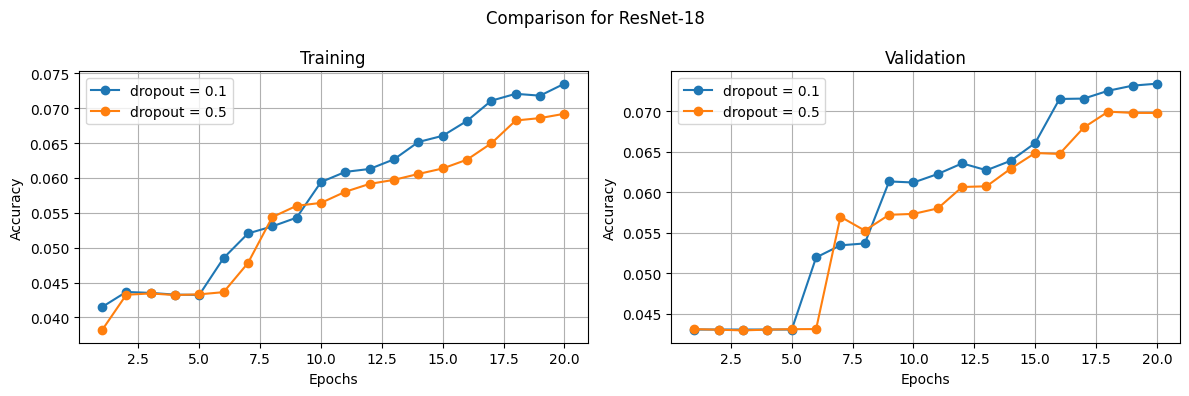

In [ ]:
train_acc_01, eval_acc_01, _, _ = extract(resnet_01)
train_acc_05, eval_acc_05, _, _ = extract(resnet_05)

plot_comparison(train_acc_01,train_acc_05,eval_acc_01,eval_acc_05)

As depicted in the plots, adopting a reduced dropout rate of 0.1 leads to better performance in terms of accuracy. This improvement can be attributed to the fact that a lower dropout rate enables the model, particularly in the initial stages when it possesses limited knowledge of the training data, to preserve more information. This, in turn, facilitates a more efficient learning process.

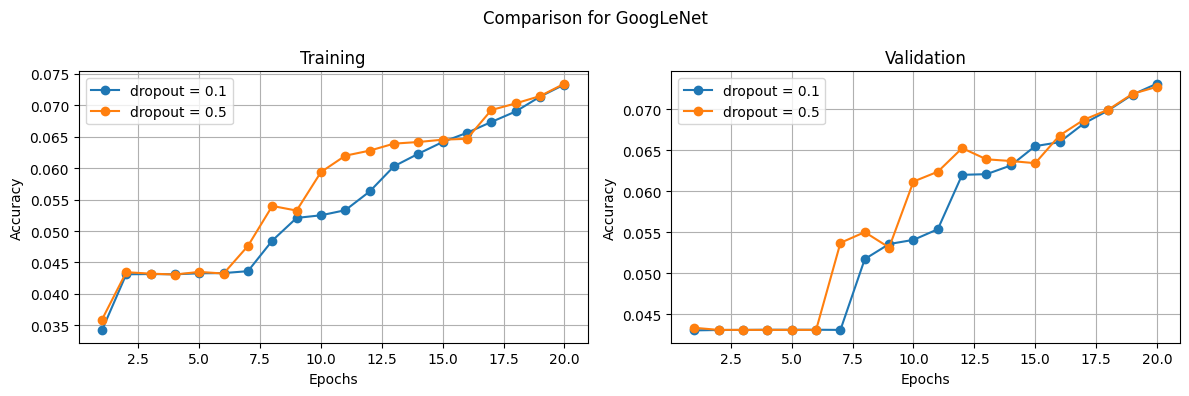

In [ ]:
train_acc_01, eval_acc_01, _, _ = extract(googlenet_01)
train_acc_05, eval_acc_05, _, _ = extract(googlenet_05)

plot_comparison(train_acc_01,train_acc_05,eval_acc_01,eval_acc_05, net='GoogLeNet')


Considering the final validation accuracy, it seems that adopting a lower dropout rate of 0.1 yields better performance in terms of accuracy. Despite the marginal improvement, noticeable only in the concluding epochs, we opted for this decision since even subtle enhancements in accuracy can contribute to overall model robustness.

In the table below, a more detailed presentation of the values is depicted.



In [ ]:
df_googlenet = pd.DataFrame({'Train accuracy (d=0.1)': train_acc_01,
                   'Train accuracy (d=0.5)': train_acc_05,
                   'Eval accuracy (d=0.1)': eval_acc_01,
                   'Eval accuracy (d=0.5)': eval_acc_05})

df_googlenet.index = [i + 1 for i in df_googlenet.index]

df_googlenet

,Train accuracy (d=0.1),Train accuracy (d=0.5),Eval accuracy (d=0.1),Eval accuracy (d=0.5)
1,0.041477,0.038142,0.043085,0.043133
2,0.043654,0.043248,0.043085,0.043064
3,0.043518,0.043442,0.043085,0.042980
4,0.043270,0.043207,0.043085,0.043075
5,0.043228,0.043310,0.043085,0.043129
6,0.048516,0.043625,0.051964,0.043141
7,0.052037,0.047798,0.053457,0.056980
8,0.053056,0.054389,0.053691,0.055274
9,0.054308,0.056007,0.061325,0.057221
10,0.059409,0.056421,0.061196,0.057328


### Comparison between GoogLeNet and ResNet

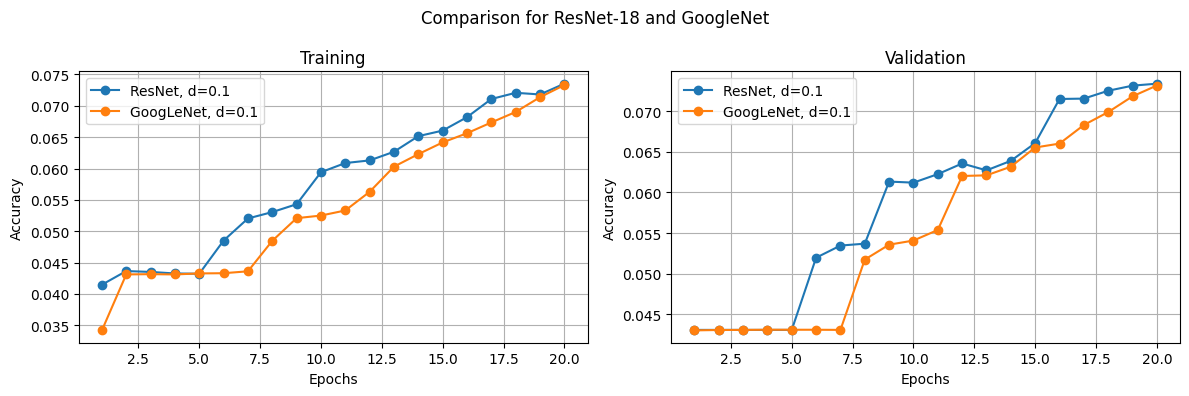

In [ ]:
train_acc_01_resnet, eval_acc_01_resnet, _, _ = extract(resnet_01)
train_acc_01_googlenet, eval_acc_01_googlenet, _, _ = extract(googlenet_01)

plot_comparison(train_acc_01_resnet,train_acc_01_googlenet,eval_acc_01_resnet,eval_acc_01_googlenet, first_label='ResNet, d=0.1', second_label='GoogLeNet, d=0.1', net='ResNet-18 and GoogleNet')

The comparative analysis reveals that, with the selected dropout rate of 0.1, ResNet outperforms GoogLeNet. The efficiency of ResNet at this dropout rate suggests a more favorable balance between regularization and feature utilization for the specific task at hand.

The same results are depicted in a tabular form below.

In [ ]:
df = pd.DataFrame({'Train accuracy ResNet (d=0.1)': train_acc_01_resnet,
                   'Train accuracy GoogleNet (d=0.1)': train_acc_01_googlenet,
                   'Eval accuracy ResNet (d=0.1)': eval_acc_01_resnet,
                   'Eval accuracy GoogleNet (d=0.1)': eval_acc_01_googlenet})

df.index = [i + 1 for i in df.index]

df

,Train accuracy ResNet (d=0.1),Train accuracy GoogleNet (d=0.1),Eval accuracy ResNet (d=0.1),Eval accuracy GoogleNet (d=0.1)
1,0.041477,0.034200,0.043085,0.043025
2,0.043654,0.043119,0.043085,0.043074
3,0.043518,0.043161,0.043085,0.043083
4,0.043270,0.043118,0.043085,0.043104
5,0.043228,0.043278,0.043085,0.043104
6,0.048516,0.043312,0.051964,0.043104
7,0.052037,0.043616,0.053457,0.043085
8,0.053056,0.048478,0.053691,0.051732
9,0.054308,0.052084,0.061325,0.053568
10,0.059409,0.052501,0.061196,0.054075


# **Testing**

Thus, the Res-Net-18 model with dropout rate 0.1 was selected as the optimal one, and the final training on 20.000 observations is implemented below.

## ResNet-18 pretrained

To further optimize the training process, transfer learning approach was used: the weights pretrained on the ImageNet dataset were implemented for the ResNet-18. For that, the PyTorch Vision <a href = "https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html" target = "_blank">RESNET18</a> pretrained model was implemented in the encoder. Some changes were implemented in the structure, specifically, the single input channel was accounted for. Additionally, the final fully connected layer was replaced such that to guarantee that the output size corresponds to the embedding dimensions used in the decoder.

To facilitate the training process, some of the layers in the ResNet-18 were frozen. In particular, all initial layers up to the third residual block were frozen. This approach allows to take advantage of the weights pretrained on the large-scale dataset, while preserving flexibility in the later layers, guaranteeing that the optimization process fine-tunes the final output for the specific task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, dropout, net = None):
        super(EncoderCNN, self).__init__()

        # Load ResNet-18 pretrained model
        resnet18 = models.resnet18(pretrained=True)

        # Modify the first convolutional layer for 1 channel input
        resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last fully connected layer
        modules = list(resnet18.children())[:-1]

        # Set up sequential module
        self.resnet18 = nn.Sequential(*modules)

        # Freeze specified layers
        self.freeze_layers(['conv1', 'bn1', 'layer1', 'layer2'])

        # Set the number of features of the ResNet-18
        num_features = resnet18.fc.in_features

        # Set up the linear layer to replace the one removed
        self.linear = nn.Linear(num_features, embed_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def freeze_layers(self, layer_names):
        # Freeze specified layers
        for name, param in self.resnet18.named_parameters():
            if any(layer_name in name for layer_name in layer_names):
                param.requires_grad = False

    def forward(self, images):
        features = self.resnet18(images)
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.relu(features)
        features = self.dropout(features)
        return features

In [ ]:
import torchinfo
mod = Image_to_Caption (200, 256, 16537, 2, 0.1, net = "GoogleNet")
torchinfo.summary(mod, [(1,224,224),(100,)], batch_dim = 0, col_names = ("input_size", "output_size", "num_params"), dtypes = [torch.float, torch.long],verbose = 0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 22.6MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
Image_to_Caption                                   [1, 1, 224, 224]          [1, 101, 16537]           --
├─EncoderCNN: 1-1                                  [1, 1, 224, 224]          [1, 200]                  --
│    └─Sequential: 2-1                             [1, 1, 224, 224]          [1, 512, 1, 1]            --
│    │    └─Conv2d: 3-1                            [1, 1, 224, 224]          [1, 64, 112, 112]         3,136
│    │    └─BatchNorm2d: 3-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           147,968
│    │    └─Sequential: 3-6     

## Data loading

Since the dataset used for the testing step differs from the one previously used, it is necessary to perform the preliminary steps.

In [ ]:
train_cap, train_img, img_dirs_train = load_data ("train", 20)
test_cap, test_img, img_dirs_test = load_data ("test", 20, isTest = True)

In [ ]:
zip_file_path = '/content/drive/MyDrive/dl_project/extracted_data/img.zip'
extracted_dir = '/content/drive/MyDrive/images_20k/train'
i = 0
current_folder = 1
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for dirs in img_dirs_train:
        file_name_pattern = f'share-task-img-mask/arxiv/train/{dirs}'
        try:
            if i > 0:
              if i % 1000 == 0:
                print(f"Extracted another 1k pngs to folder {current_folder}")
                current_folder += 1
            folder_path = os.path.join(extracted_dir, str(current_folder))
            zip_ref.extract(file_name_pattern, folder_path)
            i += 1
        except KeyError:
            print(f"File not found: {file_name_pattern}")

print("Extraction complete.")

In [ ]:
extraction_path = '/content/drive/MyDrive/images_20k/test'
png_saver (zip_file_path, extraction_path, img_dirs_test, isTest = True)

In [ ]:
captions_train = train_cap [['image_id', 'caption']]
captions_test = test_cap [['image_id', 'caption']]
text_processing (captions_train)
text_processing (captions_test)

In [ ]:
import numpy as np
vocab = dict()
for _, row in captions_train.iterrows():
    sentence = nlp.tokenizer(row['caption'])
    for word in sentence:
        if word.text not in ["SOS", "EOS"]:
            if word.text not in vocab:  # Use word.text as the key
                vocab[word.text] = 1
            else:
                vocab[word.text] += 1

In [ ]:
label2id = {str (k): (v + 4) for v, k in enumerate(vocab)} # select the index
id2label = {(v + 4): str (k) for v, k in enumerate(vocab)}
id2label [0] = "PAD"
id2label [1] = "SOS"
id2label [2] = "EOS"
id2label [3] = "UNK"
label2id ["PAD"] = 0
label2id ["SOS"] = 1
label2id ["EOS"] = 2
label2id ["UNK"] = 3

In [ ]:
captions_train ['encodings'] = captions_train ['caption'].apply(lambda x: create_tokens(x, label2id))
captions_test ['encodings'] = captions_test ['caption'].apply(lambda x: create_tokens(x, label2id))

In [ ]:
glove_matrix = np.zeros((len(vocab) + 4, embedding_dim)) # for the unknown
for id, lab in id2label.items():
  embedding_vector = embeddings_index.get(lab)
  if embedding_vector is not None:
    glove_matrix [id] = embedding_vector
glove_embeddings = torch.tensor(glove_matrix).to(device)
glove_embeddings=glove_embeddings.float()

## <b>Training the optimal model</b>

The final training was performed on 50 epochs.

In [ ]:
last_batch_loss, train_accuracy_list, train_loss_list, train_bleu_list, eval_accuracy_list, eval_loss_list, eval_bleu_list= train (num_epochs = 50, dropout = 0.1,
             isTesting = True, from_checkpoint = False, checkpoint_name = "testing_results")

## **Final results**

In [ ]:
checkpoint_path = '/content/drive/MyDrive/dl_project/extracted_data/final/testing_results.pt'
test = torch.load(checkpoint_path, map_location=torch.device('cpu'))

labels=test['labels']
predictions=test['predictions']

In [ ]:
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')
# weighted to take into account class imbalances
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')
smoothie = SmoothingFunction().method1
# smoothie to avoid division by zero
bleu_score = corpus_bleu(labels, predictions, smoothing_function=smoothie)

In [ ]:
results_dict = {
    "accuracy": [accuracy],
    "precision": [precision],
    "recall": [recall],
    "f1": [f1],
    "bleu": [bleu_score]
}

# Pandas DataFrame
results_df = pd.DataFrame(results_dict)
results_df

,accuracy,precision,recall,f1,bleu
0,0.087995,0.048109,0.087995,0.057118,0.00001


Where:

 - __Accuracy__ represents the ratio of correctly predicted instances to the total instances in the dataset.
 -  __Precision__ is the ratio of correctly predicted positive observations to the total predicted positives. It assesses the model's ability to avoid false positives. It's computed as: $\frac{True \  positive}{True \  positive+False \  positive}$
 - __Recall__ is the ratio of correctly predicted positive observations to the all observations in the actual class. It measures the model's ability to capture all the relevant instances. It's computed as: $\frac{True \  positive}{True \  positive+False \  negative}$
 - __F1 score__ is the harmonic mean of precision and recall. It provides a balanced measure that considers both false positives and false negatives. It is particularly useful when there is an uneven class distribution.It's computed as: $ 2 \times \frac{Precision \  \cdot \  Recall}{Precision \  + \  Recall}$

The small precision with respect to the other metrics indicates that the model is making a relatively higher number of false positive predictions compared to the overall correct predictions.
Moreover, a Bleu score of 0.00001 indicates an extremely low level of similarity between the generated translation and the reference translations.

The ultimate accuracy, achieved with the utilization of pretraining, surpasses the accuracy obtained without pretraining by approximately 2%. While this improvement may seem modest, it is noteworthy considering the scale of the values involved and the inherent complexity of the problem at hand.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

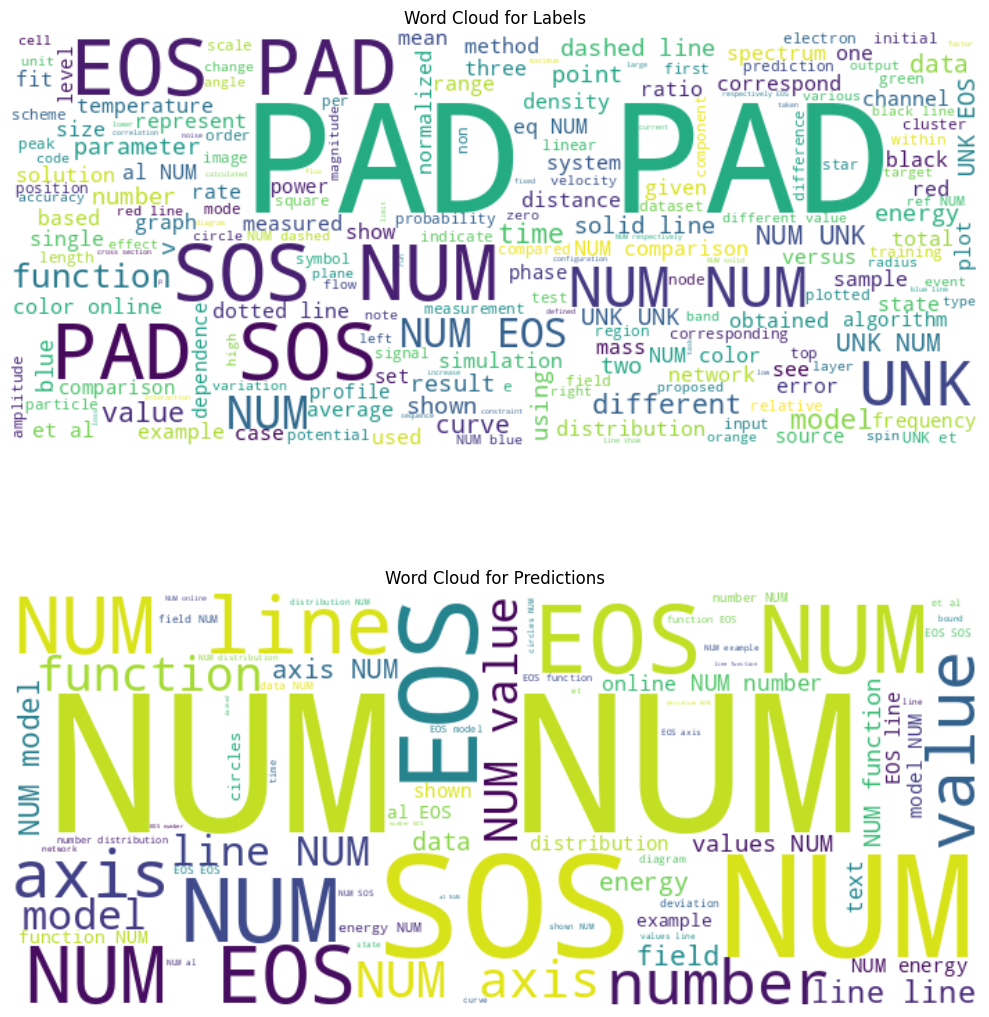

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the strings into a single text for labels and predictions
text_labels = ' '.join(labels)
text_predictions = ' '.join(predictions)

# word clouds for labels and predictions
wordcloud_labels = WordCloud(width=700, height=300, background_color='white').generate(text_labels)
wordcloud_predictions = WordCloud(width=700, height=300, background_color='white').generate(text_predictions)

plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_labels, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Labels')

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_predictions, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Predictions')

plt.tight_layout()
plt.show()


Transitioning from the first to the second figure, a notable shift in the distribution of prevalent words becomes evident. The most frequently occurring words include "PAD," "SOS," and "NUM." These terms serve distinct purposes: "PAD" for padding sequences to a uniform length, "SOS" to signal the start of a sequence, and "NUM" to collectively represent all numerical values along with the word "Figure." Given their specific roles, it is expected that these words dominate the frequency counts.

In contrast, the true captions exhibit a more diverse presence of words throughout the text. However, during the word prediction process, the model tends to emphasize the occurrence of these common words, struggling to discern different linguistic patterns. This indicates a need for further training to ensure the model effectively learns and generalizes from the data, especially when faced with unseen examples.

Despite this challenge, some positive signs emerge in the generated data. Words such as "value," "number," and "function" start to make appearances, suggesting that the model is gradually adapting to the provided captions. This incremental incorporation of diverse vocabulary indicates a potential for improved generalization as the model continues to train and refine its understanding of the underlying patterns in the scientific plot captions.

# <b>Conclusions</b>

Due to the difficulty of the presented problem, as well as the complicated nature of the data, it was not possible to achieve good perfomrance and high values for the metrics for the evaluation of the model.

Nevertheless, there exist possibilities for improvements to be implemented to the setting and the architecture in the future. As such, aside from increasing the number of images used for the analysis and the number of epochs, which can be possible with better access to computational resources, one option could be to introduce a preliminary step where the ResNet-18 pretrained encoder would be additionally fine-tuned on the FigCap dataset (Zhang et al. (2023)), which comprises of synthetically generated scientific figures. This implementation might provide a better tuning for the weights of the ResNet-18, especially in the initial layers that are aimed at feature extraction.

Another suggestion might be to implement advanced text normalization techniques as proposed in He et al. (2016): for instance, the mathematical formulas and equations can be replaced by the token EQUATIION using machine learning techniques at the preliminary steps of the analysis.

# <b>References</b>

<ol>
	<li> Chen, Charles, Ruiyi Zhang, Eunyee Koh, Sungchul Kim, Scott Cohen, Tong Yu, Ryan Rossi, and Razvan Bunescu. 2019. “Figure Captioning with Reasoning and Sequence-Level Training.” arXiv Preprint arXiv:1906.02850. </li>
	<li>Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. MIT press.</li>
<li>He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. 2016. “Deep Residual Learning for Image Recognition.” In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770–78. </li>
<li>Hsu, Ting-Yao, C Lee Giles, and Ting-Hao’Kenneth’Huang. 2021. “SciCap: Generating Captions for Scientific Figures.” arXiv Preprint arXiv:2110.11624. </li>
<li>Ioffe, Sergey, and Christian Szegedy. 2015. “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” In International Conference on Machine Learning, 448–56. pmlr. </li>
<li>Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E Hinton. 2012. “Imagenet Classification with Deep Convolutional Neural Networks.” Advances in Neural Information Processing Systems 25. </li>
<li>Papineni, Kishore, et al. "Bleu: a method for automatic evaluation of machine translation." Proceedings of the 40th annual meeting of the Association for Computational Linguistics. 2002.</li>
<li>Pennington, Jeffrey, Richard Socher, and Christopher D Manning. 2014. “Glove: Global Vectors for Word Representation.” In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP), 1532–43. </li>
<li>Simonyan, Karen, and Andrew Zisserman. 2014. “Very Deep Convolutional Networks for Large-Scale Image Recognition.” arXiv Preprint arXiv:1409.1556. </li>
<li>Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.</li>
<li>Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.</li>
<li>Zhang, Aston, Zachary C. Lipton, Mu Li, and Alexander J. Smola. 2023. Dive into Deep Learning. Cambridge University Press. </li>
</ol>
